In [13]:
import xarray as xr
import os

expname='res1'
timestep='00011680'
oce = os.path.join('/lus/h2resw01/scratch/ccpd/martini', expname + '_' + timestep + '_restart.nc')
xfield = xr.open_dataset(oce)
xfield
#varlist = ['tn', 'tb']
#for var in varlist: 
#    xfield[var] = xfield[var].where(xfield[var] != 0, xfield[var] - 0.5)

<xarray.Dataset>
Dimensions:       (y: 331, x: 360, nav_lev: 75, time_counter: 1)
Coordinates:
  * nav_lev       (nav_lev) float32 0.5 1.55 2.661 ... 5.698e+03 5.902e+03
  * time_counter  (time_counter) float32 1.168e+04
Dimensions without coordinates: y, x
Data variables: (12/40)
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    kt            float64 ...
    ndastp        float64 ...
    adatrj        float64 ...
    ntime         float64 ...
    ...            ...
    sshn          (time_counter, y, x) float64 ...
    un            (time_counter, nav_lev, y, x) float64 ...
    vn            (time_counter, nav_lev, y, x) float64 ...
    tn            (time_counter, nav_lev, y, x) float64 ...
    sn            (time_counter, nav_lev, y, x) float64 ...
    rhop          (time_counter, nav_lev, y, x) float64 ...
Attributes:
    file_name:  /lus/h2resw01/scratch/ccpd/martini/res1_00011680_restart.nc
    TimeStamp:  12/10/2023 09:13:38 -0000

In [7]:
xfield['tn'][0,0,0,0].values

array(0.)

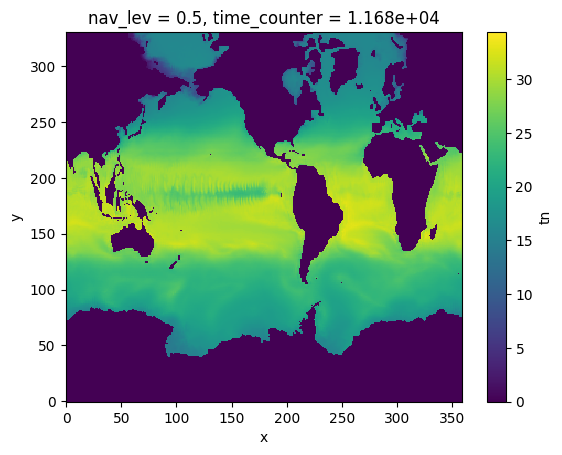

In [17]:
xfield['tn'][0,0,:,:].plot()

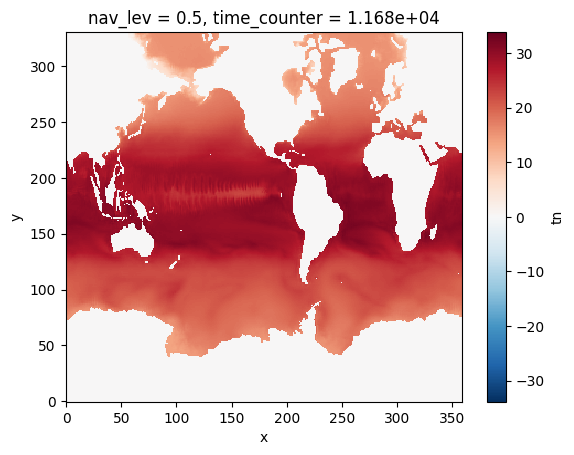

In [22]:
varlist = ['tn']
for var in varlist: 
    newfield = xr.where(xfield[var]!=0, xfield[var] - 0.5, 0.)


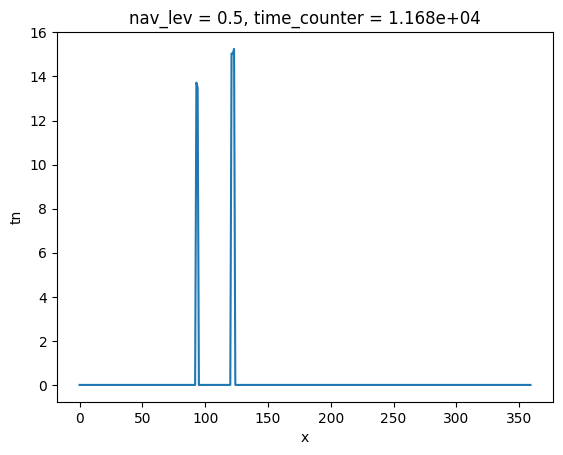

In [28]:
field[0,0,40,:].plot()